In [2]:
import tensorflow
tensorflow.__version__

'2.7.0'

In [3]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
cd "C:\Users\venkata subbareddy\Downloads\bhuvan\computer vision\project 2\part1"

C:\Users\venkata subbareddy\Downloads\bhuvan\computer vision\project 2\part1


In [5]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray

In [6]:
# Loading the images file

data = np.load('Part 1- Train data - images.npy', allow_pickle=True)

In [7]:
data.shape

(409, 2)

In [8]:
data[0],[0]

(array([array([[[42, 37, 34],
                [56, 51, 48],
                [71, 66, 63],
                ...,
                [23, 33, 34],
                [26, 36, 37],
                [28, 38, 39]],
 
               [[40, 35, 32],
                [51, 46, 43],
                [64, 59, 56],
                ...,
                [27, 36, 35],
                [24, 33, 32],
                [26, 35, 34]],
 
               [[43, 38, 35],
                [51, 46, 43],
                [61, 56, 53],
                ...,
                [28, 30, 27],
                [33, 35, 32],
                [35, 37, 34]],
 
               ...,
 
               [[56, 47, 40],
                [57, 48, 41],
                [61, 52, 45],
                ...,
                [67, 48, 42],
                [55, 35, 28],
                [60, 40, 33]],
 
               [[53, 44, 37],
                [54, 45, 38],
                [57, 48, 41],
                ...,
                [59, 40, 34],
                [60, 

In [9]:
data[408][0]

array([[[106, 128, 149],
        [113, 135, 156],
        [112, 134, 155],
        ...,
        [125, 133, 154],
        [126, 134, 155],
        [126, 132, 154]],

       [[114, 136, 157],
        [102, 124, 145],
        [113, 135, 156],
        ...,
        [130, 138, 159],
        [120, 128, 149],
        [120, 128, 149]],

       [[112, 134, 155],
        [114, 136, 157],
        [110, 132, 153],
        ...,
        [121, 129, 150],
        [125, 133, 154],
        [127, 135, 156]],

       ...,

       [[ 77,  56,  53],
        [103,  82,  77],
        [ 63,  43,  36],
        ...,
        [ 59,  28,  36],
        [ 74,  41,  50],
        [ 63,  30,  39]],

       [[  8,   3,   0],
        [  6,   1,   0],
        [  7,   1,   3],
        ...,
        [ 66,  35,  43],
        [ 60,  27,  36],
        [ 59,  26,  35]],

       [[  5,  15,   7],
        [  7,  11,  10],
        [ 18,  16,  21],
        ...,
        [ 66,  33,  42],
        [ 65,  32,  41],
        [ 67,  34,  41]]

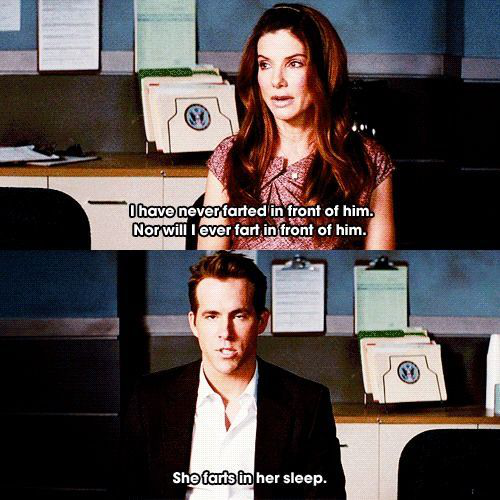

In [10]:
from PIL import Image

image = Image.open('Part 1Test Data - Prediction Image.jpeg')
image.show()
display(image)

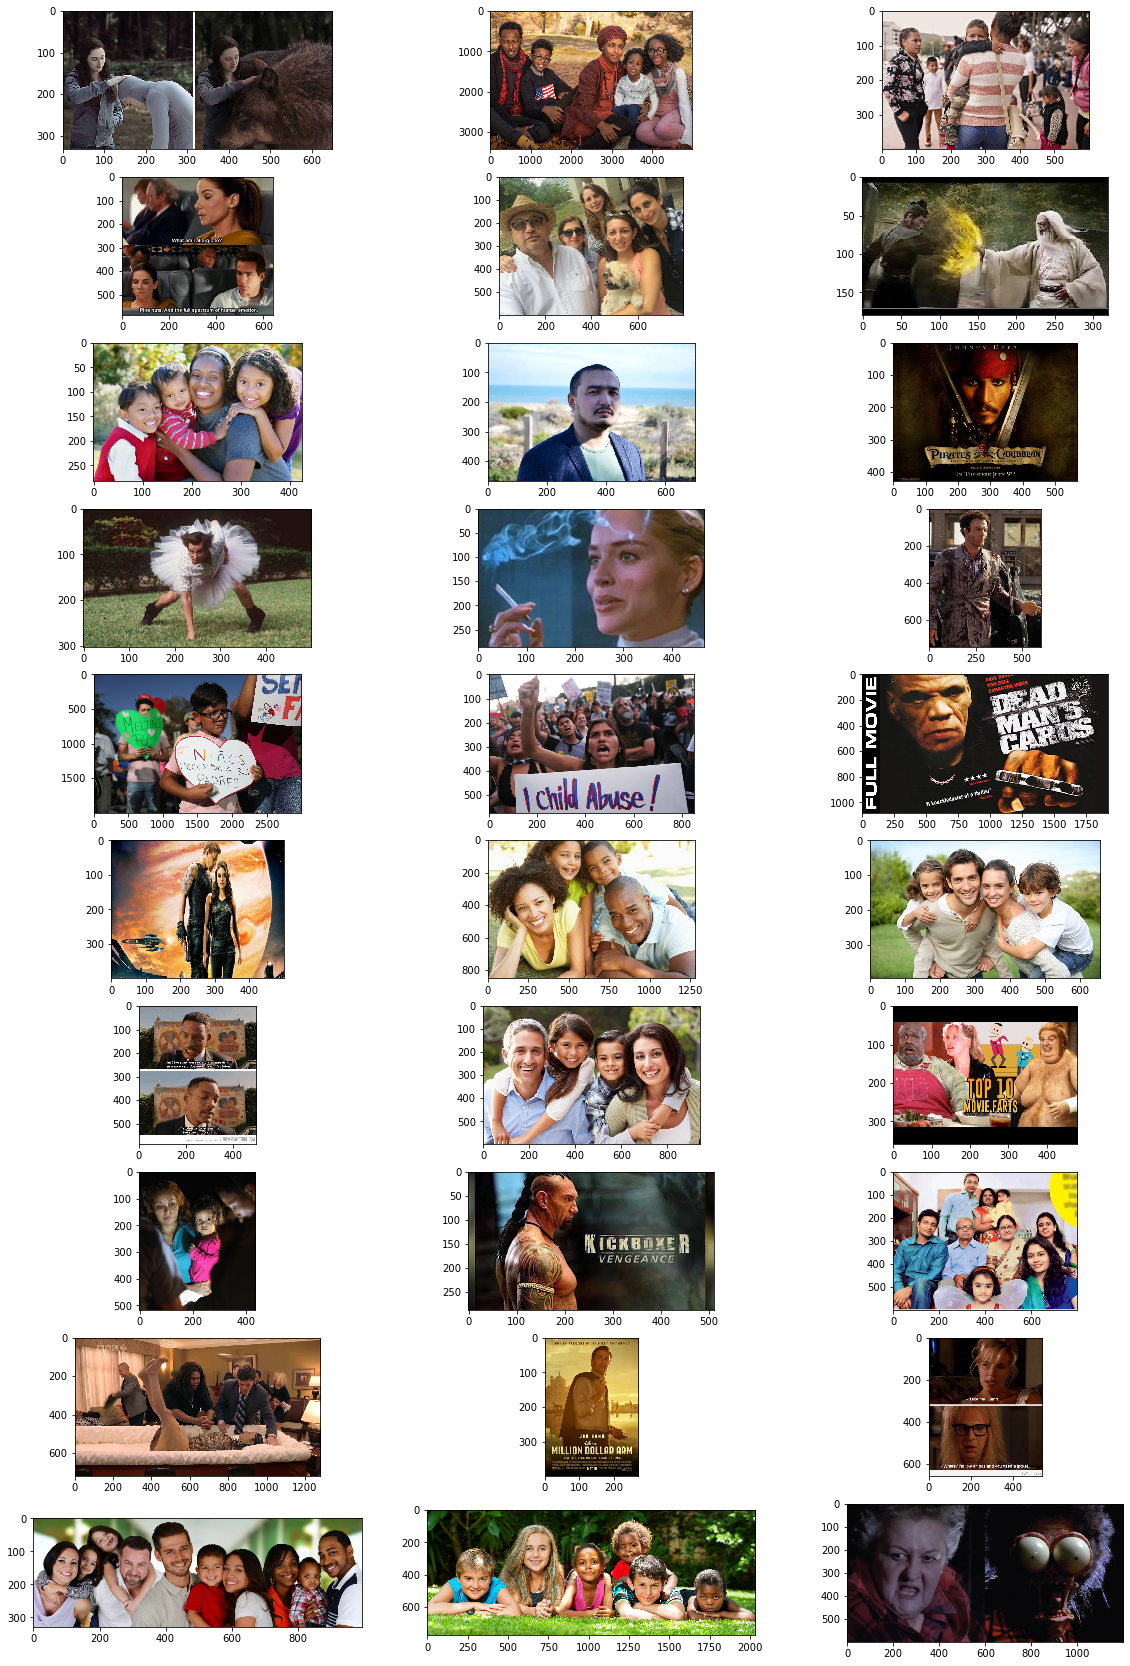

In [11]:
fi,ax = plt.subplots(10,3,figsize=(20,30))
row = 0
col = 0
index = 0
for i in range(30):
  ax[row][col].imshow(data[index][0], interpolation='nearest')
  index = index + 12
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()

In [11]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  # assign all pixels in the first 3 channels only to the image, i.e., discard the alpha channel
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


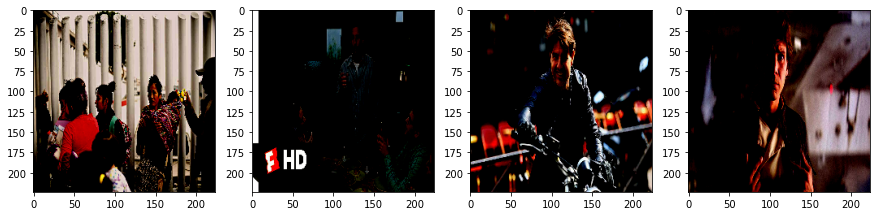

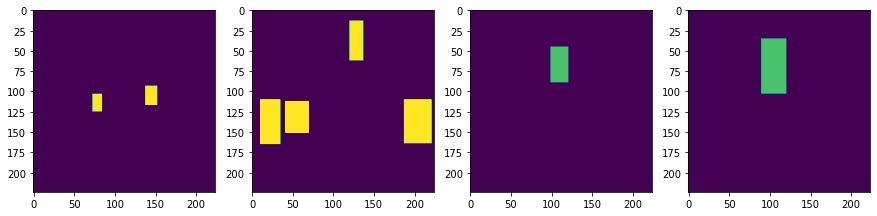

In [13]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

In [14]:
IMAGE_SIZE = 224
EPOCHS = 30
BATCH = 8
LR = 1e-4

In [15]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [16]:
model = model()
model.summary()

2031616/2019640 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                               

In [17]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [18]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [19]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [20]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
41/41 [==============================] - 88s 2s/step - loss: 0.7227 - dice_coef: 0.2773 - recall: 0.7450 - precision: 0.2577 - val_loss: 0.7577 - val_dice_coef: 0.2326 - val_recall: 1.0000 - val_precision: 0.1294 - lr: 1.0000e-04
Epoch 2/30
41/41 [==============================] - 79s 2s/step - loss: 0.6342 - dice_coef: 0.3660 - recall: 0.8747 - precision: 0.4244 - val_loss: 0.7339 - val_dice_coef: 0.2563 - val_recall: 0.9982 - val_precision: 0.1411 - lr: 1.0000e-04
Epoch 3/30
41/41 [==============================] - 77s 2s/step - loss: 0.6063 - dice_coef: 0.3937 - recall: 0.8956 - precision: 0.4554 - val_loss: 0.6774 - val_dice_coef: 0.3114 - val_recall: 0.9836 - val_precision: 0.2372 - lr: 1.0000e-04
Epoch 4/30
41/41 [==============================] - 84s 2s/step - loss: 0.5901 - dice_coef: 0.4103 - recall: 0.9096 - precision: 0.4804 - val_loss: 0.6374 - val_dice_coef: 0.3511 - val_recall: 0.9676 - val_precision: 0.3239 - lr: 1.0000e-04
Epoch 5/30
41/41 [==================

In [21]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

3/3 [==============================] - 1s 217ms/step - loss: 0.4419 - dice_coef: 0.5568 - recall: 0.6799 - precision: 0.7366


[0.4419412612915039,
 0.5568313598632812,
 0.6799066066741943,
 0.7366405725479126]

In [22]:
filename = './Part 1Test Data - Prediction Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [23]:
feat_scaled

array([[[ 0.5686275 ,  0.4666667 ,  0.45098042],
        [ 0.56078434,  0.45882356,  0.4431373 ],
        [ 0.5764706 ,  0.47450984,  0.45882356],
        ...,
        [-0.17647058, -0.5058824 , -0.73333335],
        [-0.27058822, -0.49019605, -0.75686276],
        [-0.27843136, -0.47450978, -0.7411765 ]],

       [[ 0.6       ,  0.49803925,  0.48235297],
        [ 0.6       ,  0.4901961 ,  0.48235297],
        [ 0.6313726 ,  0.5294118 ,  0.5137255 ],
        ...,
        [-0.20784312, -0.52156866, -0.7490196 ],
        [-0.16862744, -0.40392154, -0.6627451 ],
        [-0.19215685, -0.41176468, -0.6784314 ]],

       [[ 0.54509807,  0.45098042,  0.41960788],
        [ 0.47450984,  0.3803922 ,  0.34901965],
        [ 0.5372549 ,  0.4431373 ,  0.4039216 ],
        ...,
        [-0.14509803, -0.42745095, -0.6627451 ],
        [-0.3098039 , -0.5686275 , -0.827451  ],
        [-0.34117645, -0.5921569 , -0.8509804 ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [24]:
y_pred = model.predict(np.array([feat_scaled]))
y_pred

array([[[[0.14703175],
         [0.13426527],
         [0.12885618],
         ...,
         [0.08197355],
         [0.09326458],
         [0.14919424]],

        [[0.13822633],
         [0.10997865],
         [0.10476017],
         ...,
         [0.0836077 ],
         [0.08504018],
         [0.09558871]],

        [[0.13062862],
         [0.10366824],
         [0.10290337],
         ...,
         [0.07673055],
         [0.0743092 ],
         [0.07531545]],

        ...,

        [[0.10240459],
         [0.0656392 ],
         [0.08322042],
         ...,
         [0.09882361],
         [0.09303287],
         [0.09100965]],

        [[0.08751169],
         [0.05196211],
         [0.04537129],
         ...,
         [0.09678015],
         [0.10232726],
         [0.09469429]],

        [[0.14327458],
         [0.10338223],
         [0.07060048],
         ...,
         [0.1320059 ],
         [0.13650808],
         [0.14183733]]]], dtype=float32)

In [25]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


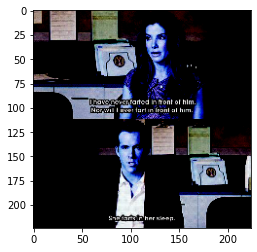

In [26]:
plt.imshow(feat_scaled)

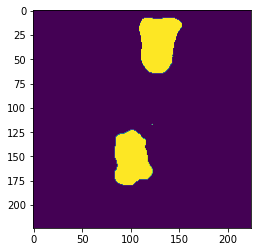

In [27]:
plt.imshow(pred_mask)